### time-series
* track/sliding/test window size: 57435, 34452, 11484
* walk-forward validation

In [2]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [3]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [4]:
import logging
set_logger(logging.DEBUG)

In [5]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions']


In [6]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1475109, 25)
(709325, 22)


In [7]:
pp = Preprocess(df_transaction, df_property)
use_features = pp.get_feature_list()
use_features = ['date', 'sqft', 'num_bed', 'num_bath', 'view', 'pool', 
                'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 
                'impr_over_land', 'lon', 'lat', 'zip']
use_features

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat',
 'zip']

In [8]:
# records of last 2 years
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] transforming eval
[dp] transforming eval_sqft_price
[dp] making sqft_zip_avg
[dp] making sqft_over_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making eval_zip_avg
[dp] making eval_over_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(68906, 18)

In [9]:
monthly_volume = int(df_track.shape[0] / 24)
df_track.head()

,sqft,id,sqft_zip_avg,lat,sold_price,zip,sold_price_zip_avg,sqft_over_zip_avg,eval_over_zip_avg,lon,sqft_price_zip_avg,num_bath,eval_zip_avg,view,date,num_bed,impr_over_land,pool
1,732,1392761,1678.766257,32.79673,158500,92020,429138.400703,0.436034,0.354392,-116.96671,264.264499,1.0,456186.318102,0,2015-10-01,1.0,1.250028,0
39746,3117,1392724,2411.534483,33.06851,815000,92029,625932.471264,1.292538,1.245316,-117.07649,271.863506,3.0,667540.525862,0,2015-10-01,4.0,1.742629,1
40442,1301,1392725,2077.993659,33.20254,408000,92084,496899.456522,0.626085,0.782437,-117.22015,251.584239,2.0,530962.631341,0,2015-10-01,3.0,2.149506,0
40443,1458,1392777,2077.993659,33.22698,365000,92084,496899.456522,0.701638,0.701177,-117.23104,251.584239,2.0,530962.631341,0,2015-10-01,3.0,1.580017,0
40444,2405,1392813,2077.993659,33.25058,635000,92084,496899.456522,1.157366,1.455846,-117.22204,251.584239,2.0,530962.631341,1,2015-10-01,3.0,1.190484,1


### LinearRegression

In [10]:
# walk-forward validation
# K-fold cross validation
from sklearn.linear_model import Ridge
rr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ElasticNet(random_state=42))
     ])
parameters = {'clf__l1_ratio': [0.05, 0.07, 0.1, 0.12, 0.14],
              'clf__alpha': [0.01, 0.03, 0.05, 0.07, 0.09]}

mm = ModelManager(df_track, use_features, rr, time_series=True)
mm.run(param_grid=parameters, GridSearchCV={'verbose':True, 'n_jobs':-1}, sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 57422, 34452, 11484
[dp] train/valid/test size: 45937, 11485, 11484
[dp] walk-forward train:(11486,), test:(11484,)
[dp] walk-forward train:(22970,), test:(11484,)
[dp] walk-forward train:(34452,), test:(11484,)
[dp] walk-forward train:(34452,), test:(11484,)
[dp] 4-fold walk-forward validation
[dp] track_window:57422, sliding_window:34452, test_window:11484


Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished


173821.24666191966

In [11]:
mm.summary()

[dp] best params: {'clf__alpha': 0.01, 'clf__l1_ratio': 0.14}
[dp] best score: -29635601004.880943
[dp] cv results:
{'mean_fit_time': array([0.3177191 , 0.40896457, 0.40520078, 0.40908688, 0.38765466,
       0.28864157, 0.2868889 , 0.35995698, 0.28613454, 0.26695913,
       0.19413942, 0.228607  , 0.22071195, 0.21494693, 0.19526726,
       0.19075602, 0.18837571, 0.21219087, 0.17684478, 0.16945022,
       0.17446387, 0.17609251, 0.16393512, 0.18800068, 0.09863704]),
 'mean_score_time': array([0.00802195, 0.01178241, 0.01215827, 0.01128072, 0.01240981,
       0.01178235, 0.01140499, 0.01103127, 0.01027763, 0.01140577,
       0.01178235, 0.01140618, 0.01153111, 0.01115501, 0.01128155,
       0.01128107, 0.01128072, 0.01190537, 0.01102972, 0.01090598,
       0.01065308, 0.01102984, 0.01090461, 0.01065314, 0.00990099]),
 'mean_test_score': array([-2.96406857e+10, -2.96395479e+10, -2.96378497e+10, -2.96367231e+10,
       -2.96356010e+10, -2.97688560e+10, -2.97642121e+10, -2.97573158e+10,
  

[dp] training error: 173654.2685302594
[dp] testing error: 173821.24666191966


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [40]:
ntrees = np.arange(20,110,40)
depths = np.arange(7,15)
parameters = { 'n_estimators': ntrees, 'max_depth': depths}
rf = RandomForestRegressor(n_jobs=-1, random_state=17)

mm = ModelManager(df_track, use_features, rf, time_series=True)
mm.run(param_grid=parameters, sliding_window=monthly_volume*12, test_size=monthly_volume*4, GridSearchCV={'verbose':True, 'n_jobs':-1})

[dp] track/sliding/test window size: 57424, 34452, 11484
[dp] train/valid/test size: 45939, 11485, 11484
[dp] walk-forward train:(11488,), test:(11484,)
[dp] walk-forward train:(22972,), test:(11484,)
[dp] walk-forward train:(34452,), test:(11484,)
[dp] walk-forward train:(34452,), test:(11484,)
[dp] 4-fold walk-forward validation
[dp] track_window:57424, sliding_window:34452, test_window:11484


Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.8min finished


127516.17798165236

In [41]:
mm.summary()

[dp] best params: {'max_depth': 14, 'n_estimators': 100}
[dp] best score: -15909877807.678328
[dp] cv results:
{'mean_fit_time': array([0.81352258, 3.02616733, 5.1339947 , 2.05783707, 3.97064531,
       6.02527714, 1.94627482, 4.15405655, 6.47192591, 2.18121833,
       4.39833349, 7.49731642, 2.64861691, 4.92514426, 7.81135339,
       2.40093917, 5.07777268, 8.5172953 , 2.75815386, 5.55867159,
       9.39449054, 2.95216578, 6.18622804, 9.00152296]),
 'mean_score_time': array([0.26560283, 0.73333687, 0.77705145, 0.82207984, 0.76917243,
       1.03474796, 0.94240624, 0.818694  , 1.05732459, 0.75416124,
       0.85405153, 1.19434088, 0.87959641, 0.87693983, 1.09227037,
       0.95792228, 0.82818639, 1.10300207, 1.07953233, 0.81708986,
       1.2049318 , 1.07546002, 0.92853349, 0.9122141 ]),
 'mean_test_score': array([-1.94518885e+10, -1.91913593e+10, -1.91797628e+10, -1.83072595e+10,
       -1.80831435e+10, -1.80380357e+10, -1.75352468e+10, -1.73703281e+10,
       -1.72843950e+10, -1.7025

[dp] training error: 93770.00002278642
[dp] testing error: 127516.17798165236


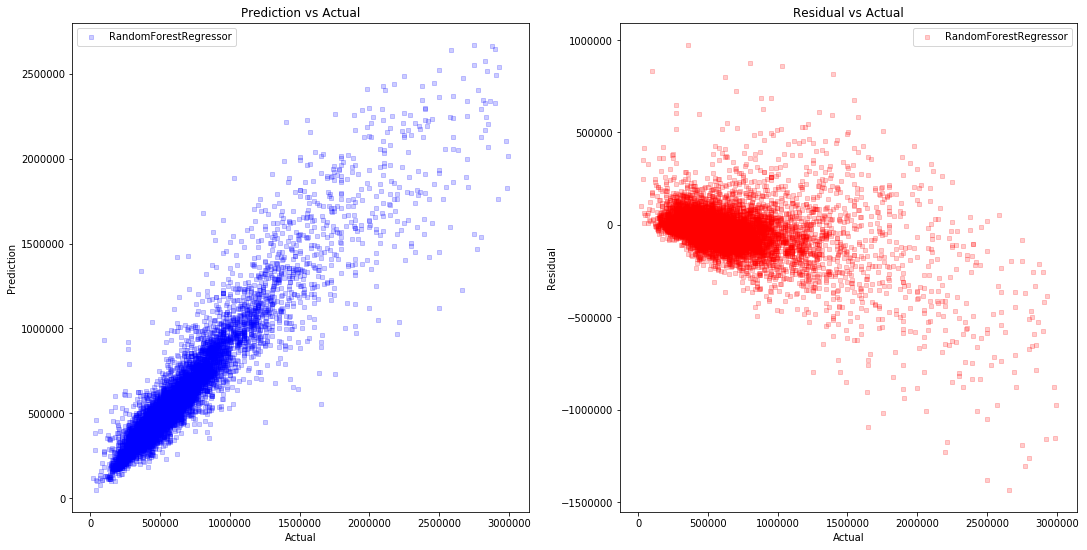

In [42]:
mm.plot_residual()

C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


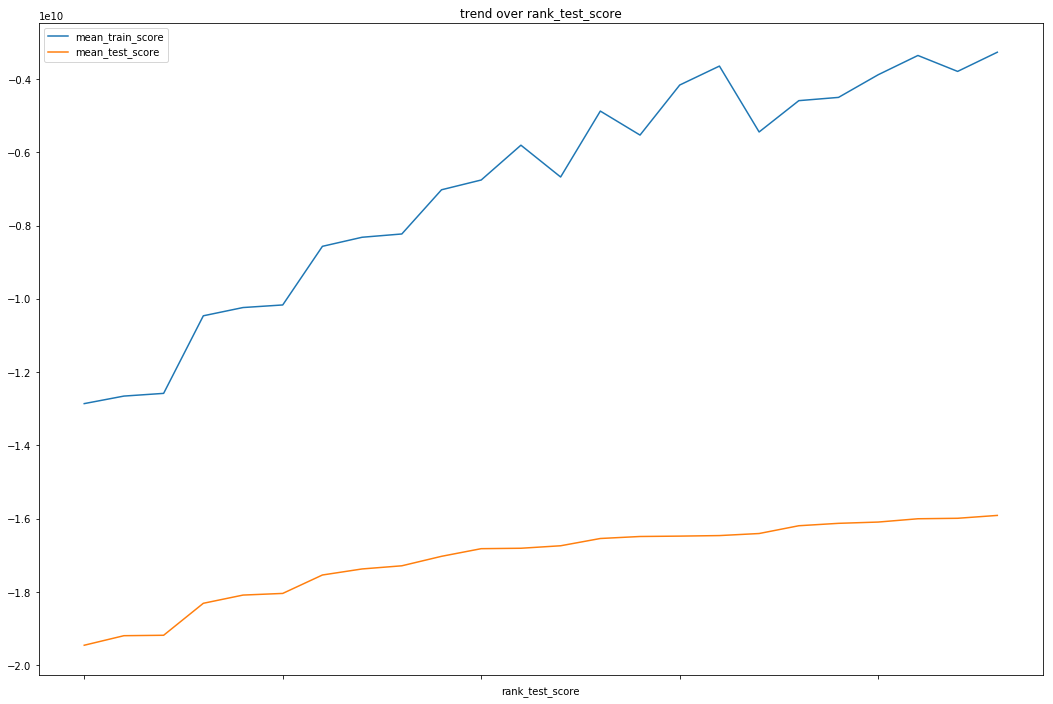

[{'max_depth': 7, 'n_estimators': 20},
 {'max_depth': 7, 'n_estimators': 60},
 {'max_depth': 7, 'n_estimators': 100},
 {'max_depth': 8, 'n_estimators': 20},
 {'max_depth': 8, 'n_estimators': 60},
 {'max_depth': 8, 'n_estimators': 100},
 {'max_depth': 9, 'n_estimators': 20},
 {'max_depth': 9, 'n_estimators': 60},
 {'max_depth': 9, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 20},
 {'max_depth': 10, 'n_estimators': 60},
 {'max_depth': 11, 'n_estimators': 20},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 12, 'n_estimators': 20},
 {'max_depth': 11, 'n_estimators': 60},
 {'max_depth': 13, 'n_estimators': 20},
 {'max_depth': 14, 'n_estimators': 20},
 {'max_depth': 11, 'n_estimators': 100},
 {'max_depth': 12, 'n_estimators': 60},
 {'max_depth': 12, 'n_estimators': 100},
 {'max_depth': 13, 'n_estimators': 60},
 {'max_depth': 14, 'n_estimators': 60},
 {'max_depth': 13, 'n_estimators': 100},
 {'max_depth': 14, 'n_estimators': 100}]

In [43]:
mm.plot_learning_curve()

ModelType.GRID_SEARCH


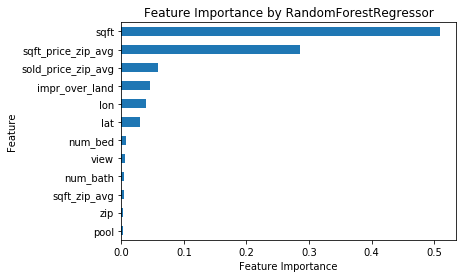

In [44]:
mm.plot_feature_importance(feature_set=mm.feature_set[1:])

### residual analysis
* check distribution of residual
* scatter plot of residual and attributes: sqrt, lon, lat to see any correlation

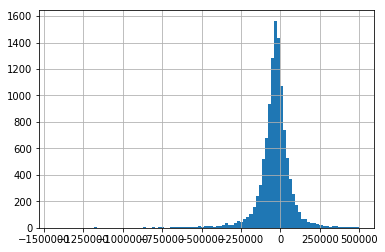

In [12]:
df_check = pp.debug(mm.get_result_df())
df_check[df_check['residual']<500000]['residual'].hist(bins=100)

In [13]:
df_check.to_csv('c:\\wenyan\\dse_capstone\\notebooks\\modeling\\dump\\baseline_residual.csv')

Text(0.5,1,'sold_price vs residual')

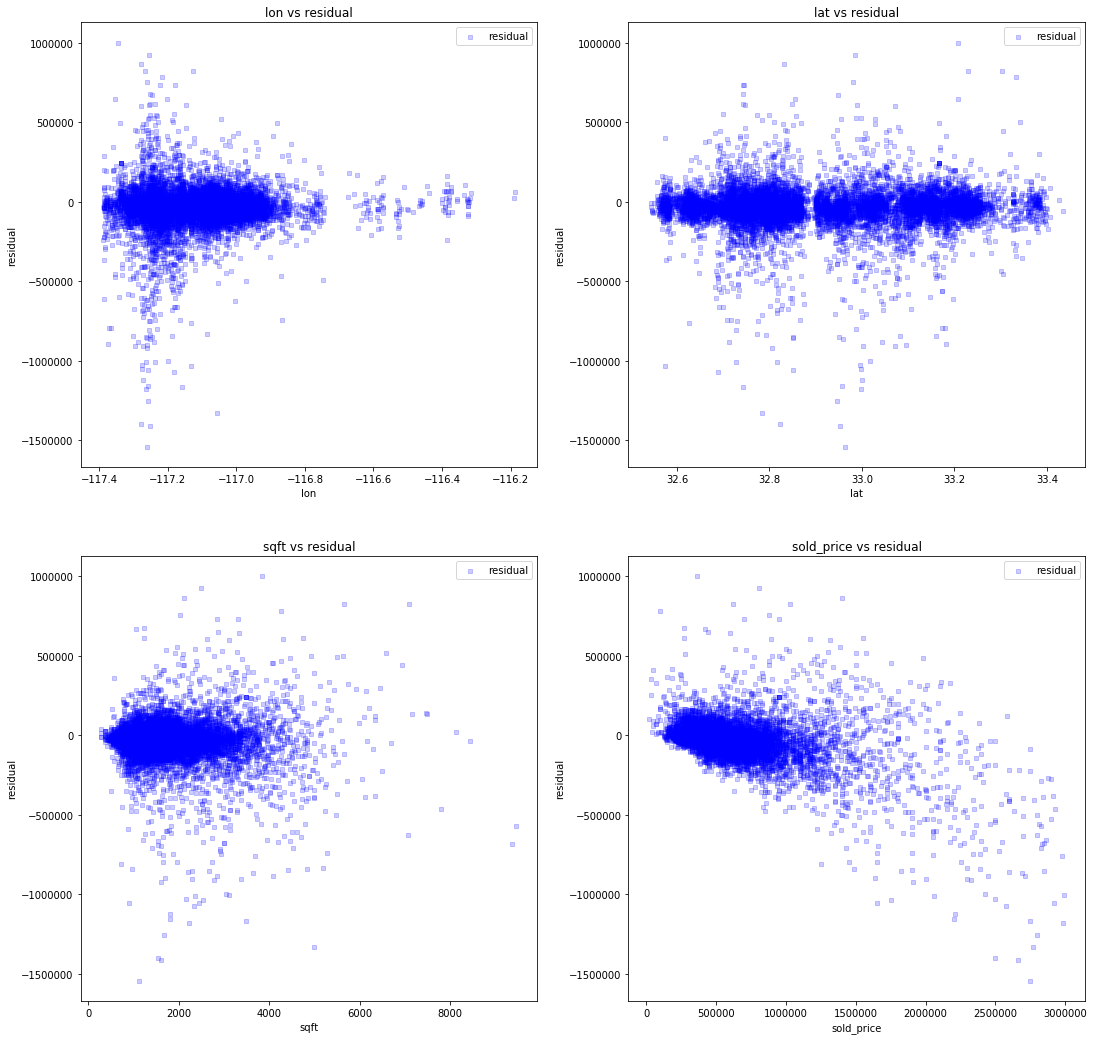

In [33]:
fig = plt.figure(figsize=(18, 18))
ax1 = fig.add_subplot(221)
ax1.scatter(df_check['lon'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('lon')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('lon vs residual')

ax1 = fig.add_subplot(222)
ax1.scatter(df_check['lat'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('lat')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('lat vs residual')

ax1 = fig.add_subplot(223)
ax1.scatter(df_check['sqft'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('sqft')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('sqft vs residual')

ax1 = fig.add_subplot(224)
ax1.scatter(df_check['sold_price'], df_check['residual'], s=10, c='b', alpha=0.2, marker="s")
plt.xlabel('sold_price')
plt.ylabel('residual')
plt.legend(loc='best');
plt.title('sold_price vs residual')

In [20]:
def remeasure(df_check, threshold=200000):
    removed = df_check[df_check['residual']>=threshold]
    print("removed records:", removed.shape[0])
    df_left = df_check[df_check['residual']<threshold]
    return sqrt(mean_squared_error(df_left['predict'], df_left['sold_price']))

remeasure(df_check)

removed records: 231


118791.39933910602

In [20]:
df_check[(df_check['residual']>=600000)]

,str_no,street,st_type,city,zip,lon,lat,sqft,sold_price,predict,residual,date,pin,land_use_subcode
2125,256,NAUTILUS,ST,LA JOLLA,92037,-117.27954,32.83124,2112,1400000,2.204266e+06,804265.569231,2017-06-28,3512706402,17
3488,3636,CURTIS,ST,SAN DIEGO,92106,-117.22378,32.74331,3318,700000,1.444355e+06,744354.980363,2017-07-11,4496701800,11
4489,839,IDA,AVE,SOLANA BEACH,92075,-117.25607,32.98449,2487,805000,1.739380e+06,934380.304806,2017-07-20,2982832600,11
5967,4955,DEL MONTE,AVE,SAN DIEGO,92107,-117.25253,32.74377,1234,271000,8.990516e+05,628051.587407,2017-08-01,4481713202,17
6721,4955,DEL MONTE,AVE,SAN DIEGO,92107,-117.25253,32.74377,1234,271000,9.683763e+05,697376.301031,2017-08-09,4481713204,17
7911,3198,CAMINO PORTOFINO,None,FALLBROOK,92028,-117.21636,33.33365,4268,100000,8.989720e+05,798972.035143,2017-08-21,1240410800,11
7916,169,PARNASSUS,CIR,OCEANSIDE,92054,-117.34536,33.20757,3848,361000,1.256497e+06,895497.175926,2017-08-22,1491001900,11
8638,9765,LITTLE CANYON,LN,ESCONDIDO,92026,-117.12678,33.23000,7100,1030000,1.877090e+06,847090.000000,2017-08-29,1854132300,11
8938,7929,AVENIDA KIRJAH,None,LA JOLLA,92037,-117.23771,32.84985,4757,1550000,2.323232e+06,773231.852642,2017-08-31,3467323300,11
9138,4912,CONEJO,RD,FALLBROOK,92028,-117.26664,33.30373,5659,620000,1.462975e+06,842974.666667,2017-08-31,1211210600,11
